### Quimb Tensor Overview
quimb is a pure python library for quantum information and many-body calculations. The main developer is Johnnie Gray.

The submodule quimb.tensor has specialised tools for tensor networks.

The two main classes here (which almost all others inherit from) are Tensor and TensorNetwork. Some of their attributes/instance variables are:
            
<ul>
  <li>Tensor
      <ul>
          <li>data - numpy ndarray to hold tensor entires</li>
          <li>inds - list of index labels (strings) (must match number of
		             dimensions of data)</li>
          <li>tags - set of tags (strings) assigned to this tensor. Used to identify the tensor when doing partial                      contractions or contracting in specified order.</li>
          <li>left_inds - list of indices to be considered the left indices when reshaping into matrix for matrix operations</li>
      </ul>
  </li>
    
  <li>TensorNetwork
      <ul>
          <li>tensor_map - dictionary that pairs the tensors of the TN (values) with unique string ids (keys). This               is where the tensors of the TN are kept.</li>
          <li>tag_map - dictionary that pairs tags (keys) with a list of the ids (values) of tensors that have that               tag</li>
          <li>ind_map - similar to tag_map but pairs index labels with lists of ids of tensors that have that index label</li>
      </ul>
  </li>
</ul>

Below we create tensors objects for the random tensors $R_{\mu\nu\sigma\rho}, X_\mu , Y_\mu , Z_\mu$ and $g_{\mu\nu}$ and then a tensornetwork object for the following expression:
$R_{\mu\nu\sigma\rho}X_\mu Y_\nu Z_\lambda g_{\sigma\lambda}$

In [5]:
import numpy as np
import quimb.tensor as qtn

# Create random data for the tensors
R_data = np.random.randn(4,4,4,4)
X_data = np.random.randn(4,)
Y_data = np.random.randn(4,)
Z_data = np.random.randn(4,)
g_data = np.random.randn(4,4)

# Create index labels for the tensors
R_inds = ('mu', 'nu', 'sigma', 'rho')
X_inds = ('mu',)
Y_inds = ('nu',)
Z_inds = ('lambda',)
g_inds = ('sigma', 'lambda')

# Create the tensors
R = qtn.Tensor(R_data, R_inds)
X = qtn.Tensor(X_data, X_inds)
Y = qtn.Tensor(Y_data, Y_inds)
Z = qtn.Tensor(Z_data, Z_inds)
g = qtn.Tensor(g_data, g_inds)

# Create the tensor network for the expression mentioned above
TN = qtn.TensorNetwork([R, X, Y, Z, g])

Tensor and TensorNetwork objects have graph methods for visualisation. Plotting is done using networkx (a python library for creating and manipulating complex graphs/networks)

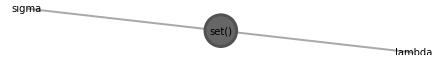

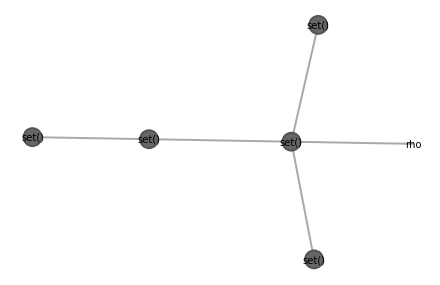

In [20]:
# Plot the tensors R and the tensor network TN
g.graph()
TN.graph()

We can then fully contract the network with the contract method.

An adjacency matrix isn't used at any stage to store how the graph is connected. Instead, when contractions are made, it looks through all the index lists 'inds' of each tensor and contracts tensors if they share an index label.

In [15]:
# Contracting this tensor network returns a vector
vec = TN.contract()

print(vec)
print(vec.data)

Tensor(shape=(4,), inds=('rho',), tags={'Group2_tag', 'Group1_tag'})
[ -4.94729558 -11.5261895   -4.03032485  -0.49697337]


All contractions are done by the contract function in opt_einsum (https://joss.theoj.org/papers/10.21105/joss.00753). It is called by passing a string of the indices before and after the contraction, along with a list of tensors to be contracted. For example, if we wanted to do the following contraction:
$C_{pi}C_{qj}I_{ijkl}C_{rk}C_{rl} = (CCICC)_{pq}$

The string opt_einsum needs to do this contraction is: '$pi,qj,ijkl,rk,rl$ -> $pq$'. This is demonstrated below.

The contract method in quimb.tensor uses the lists of index labels in tensor objects to construct the above string and passes it to opt_einsum's contract function with a list of the relevant tensors. Here's a summary of the steps it takes:
* Collect all tensor indices into a list.
* Create list of indices for the output tensor by excluding indices that
  appear twice.
* Create string expressing the contraction for einsum "(all indices) -> (output indices)".
* Do contraction by passing expression and list of tensors to einsum.

In [13]:
from opt_einsum import contract

# Create random tensors
N = 3
C = np.random.rand(N, N)
I = np.random.rand(N, N, N, N)

# Contract tensors
contracted_tensor = contract('pi,qj,ijkl,rk,rl -> pq', C, C, I, C, C)

print('The contracted tensor is: \n',contracted_tensor)

The contracted tensor is: 
 [[ 4.44178596  8.68808023  6.30776809]
 [ 8.07766379 16.22271927 10.6662472 ]
 [ 6.48774796 12.32960966  7.94602651]]


In [16]:
from opt_einsum import contract_path

path_info = contract_path('pi,qj,ijkl,rk,rl -> pq', C, C, I, C, C)

print('The contraction path is: ', path_info[0], '\n')
print(path_info[1])

The contraction path is:  [(3, 4), (2, 3), (0, 2), (0, 1)] 

  Complete contraction:  pi,qj,ijkl,rk,rl->pq
         Naive scaling:  7
     Optimized scaling:  4
      Naive FLOP count:  1.094e+4
  Optimized FLOP count:  3.240e+2
   Theoretical speedup:  33.750
  Largest intermediate:  9.000e+0 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   3           GEMM              rl,rk->lk                     pi,qj,ijkl,lk->pq
   4    GEMV/EINSUM            lk,ijkl->ij                          pi,qj,ij->pq
   3           GEMM              ij,pi->jp                             qj,jp->pq
   3           GEMM              jp,qj->pq                                pq->pq



opt_einsum uses several path finding algorithms, which can be manually specified using the optimize keyword. These are:

<ul>
  <li>The 'optimal' strategy - an exhaustive search of all possible paths
  </li>
    
  <li>The 'dynamic-programming' strategy - a near-optimal search based off dynamic-programming
  </li>
    
  <li>The 'branch' strategy - a more restricted search of many likely paths
  </li>
    
  <li>The 'greedy' strategy - finds a path one step at a time using a cost heuristic
  </li>
</ul>

Can perform contractions with numerous backends, including on the GPU and with libraries such as TensorFlow and PyTorch.

### Partial contractions
A user can label groups of Tensors, within a TensorNetwork, to be contracted together using tags. Here we put the tensors $R$ and $X$ into one group and $R, Z$ and $g$ into another. Then we show how to partially contract the TN.

In [9]:
# Create sets of tags for the tensors
R_tags = {'Group1_tag', 'Group2_tag'}
X_tags = {'Group1_tag'}
Z_tags = {'Group2_tag'}
g_tags = {'Group2_tag'}

# Create the tensors with the assigned tags
R = qtn.Tensor(R_data, R_inds, R_tags)
X = qtn.Tensor(X_data, X_inds, X_tags)
Y = qtn.Tensor(Y_data, Y_inds)
Z = qtn.Tensor(Z_data, Z_inds, Z_tags)
g = qtn.Tensor(g_data, g_inds, g_tags)

# Create the tensor network
TN = qtn.TensorNetwork([R, X, Y, Z, g])

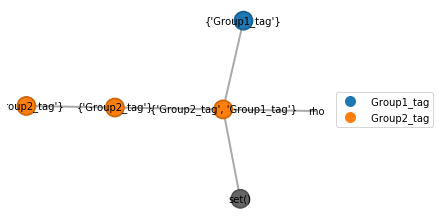

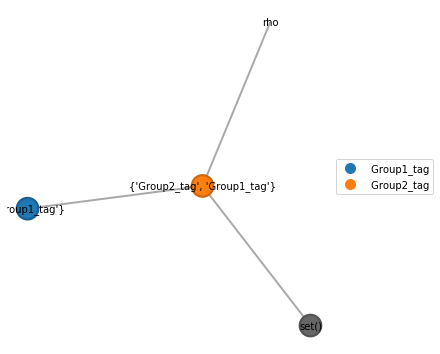

In [10]:
# Contract all tensors with the tag 'Group2_tag' into a single tensor
result = TN.contract_tags(['Group2_tag'])

# Plot the original TN with the resultant TN. Nodes are coloured according to tags
TN.graph(color=['Group1_tag', 'Group2_tag'])
result.graph(color=['Group1_tag', 'Group2_tag'])

### Quantum circuit simulation with TNs
quimb.tensor also has a class called Circuit meant for quantum circuit simulation using TNs. It has a tensor network 'psi' as an attribute for the output wavefunction of the circuit. It has methods for adding and applying gates to it.

It also includes a class method called from_qasm which generates a ciruit object for the circuit described by a qasm file or string.

In [9]:
# This is a qasm description of a circuit with 4 qubits
qasm_circuit = """4
0 h 0
0 h 1
0 h 2
1 cx 0 2
1 cx 1 3
2 cx 2 3
2 cx 0 1
3 h 0
3 h 1
3 h 2
4 cx 0 2
4 cx 1 3
5 cx 2 3
5 cx 0 1
6 h 0
6 h 1
6 h 2
7 cx 0 2
7 cx 1 3
8 cx 2 3
8 cx 0 1
"""

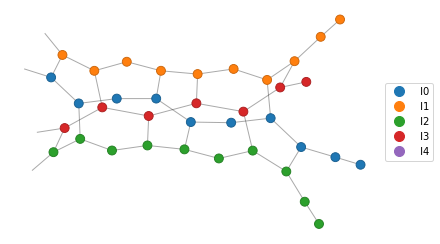

In [10]:
# Create a circuit object from the qasm description
circ = qtn.Circuit.from_qasm(qasm_circuit)

# Plot the tensor network for the circuit and colour the nodes according to the quibts
circ.psi.graph(color=[f'I{i}' for i in range(5)])

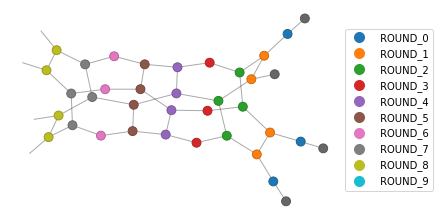

In [13]:
# Plot the tensor network and colour the nodes according to gate round
circ.psi.graph(color=[f'ROUND_{i}' for i in range(10)])